In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [2]:
#https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets ссылка на датасет
#https://www.kaggle.com/code/endaer/dataeng6/edit ссылка на блокнот в кагле
file_path = "/kaggle/input/transactions-fraud-datasets/cards_data.csv"  
chunk_size = 100000 

In [3]:
# Анализ
file_size_disk = os.path.getsize(file_path) / (1024 ** 2) 
print(f"Размер файла на диске: {file_size_disk:.2f} MB")

data = pd.read_csv(file_path)

memory_usage_initial = data.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Объем памяти в оперативной памяти: {memory_usage_initial:.2f} MB")

column_stats = []
for col in data.columns:
    col_memory = data[col].memory_usage(deep=True) / (1024 ** 2)
    col_type = data[col].dtype
    column_stats.append({
        "column": col,
        "memory_mb": col_memory,
        "memory_percent": col_memory / memory_usage_initial * 100,
        "dtype": str(col_type)
    })
column_stats_sorted = sorted(column_stats, key=lambda x: x["memory_mb"], reverse=True)

with open("column_stats_initial.json", "w") as f:
    json.dump(column_stats_sorted, f, indent=4)

Размер файла на диске: 0.49 MB
Объем памяти в оперативной памяти: 2.84 MB


In [4]:
# Оптимизации
def optimize_object_columns(df):
    for col in df.select_dtypes(include=["object"]):
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype("category")
    return df

data = optimize_object_columns(data)

def downcast_int_columns(df):
    int_cols = df.select_dtypes(include=["int", "int64"])
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast="integer")
    return df

data = downcast_int_columns(data)

def downcast_float_columns(df):
    float_cols = df.select_dtypes(include=["float", "float64"])
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast="float")
    return df

data = downcast_float_columns(data)

In [5]:
# Анализ после оптимизации
memory_usage_optimized = data.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Объем оперативной памяти после оптимизации: {memory_usage_optimized:.2f} MB")

optimized_column_stats = []
for col in data.columns:
    col_memory = data[col].memory_usage(deep=True) / (1024 ** 2)
    col_type = data[col].dtype
    optimized_column_stats.append({
        "column": col,
        "memory_mb": col_memory,
        "memory_percent": col_memory / memory_usage_optimized * 100,
        "dtype": str(col_type)
    })

with open("column_stats_optimized.json", "w") as f:
    json.dump(optimized_column_stats, f, indent=4)

Объем памяти после оптимизации: 0.56 MB


In [6]:
# Срез датасета
selected_columns = data.columns[1:11]  
subset_data = pd.read_csv(file_path, usecols=selected_columns, chunksize=chunk_size)

output_file = "subset_data.csv"
for chunk in subset_data:
    chunk.to_csv(output_file, mode="a", index=False)

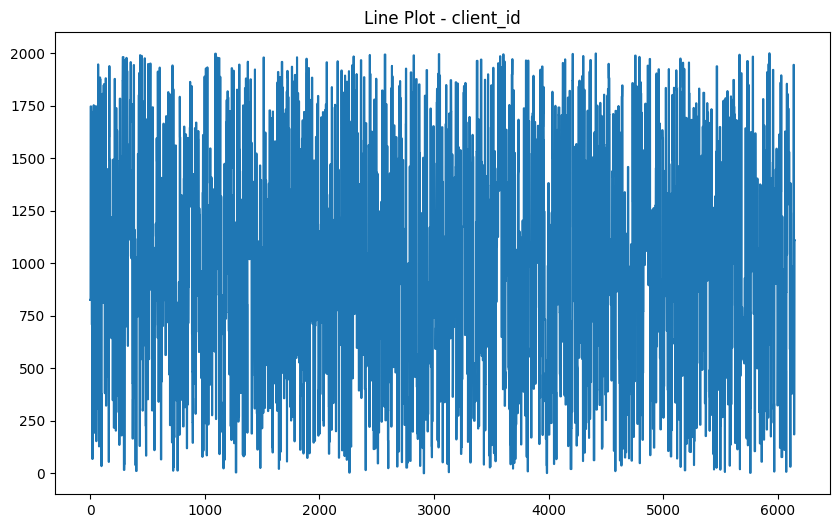

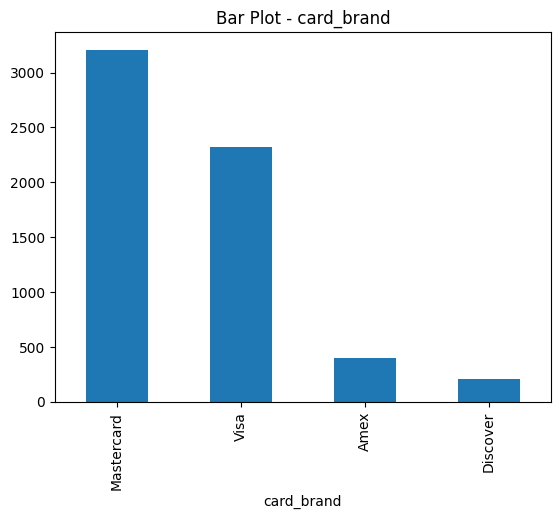

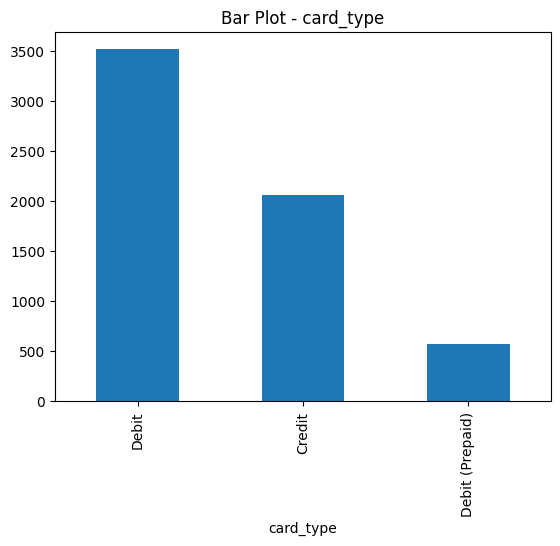

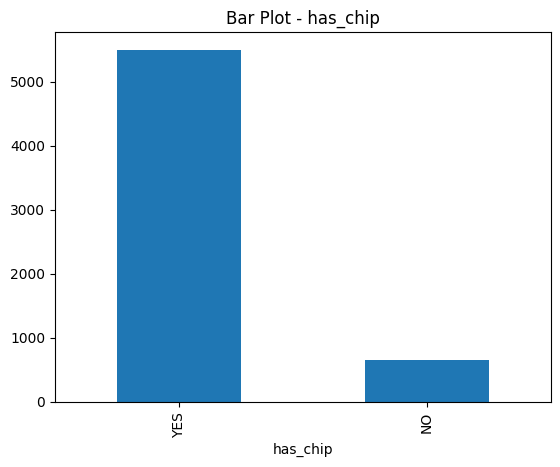

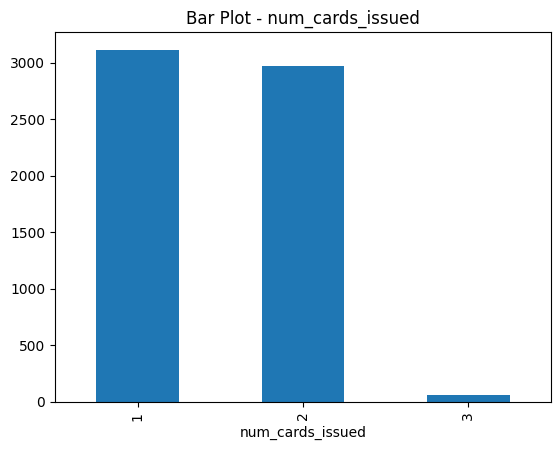

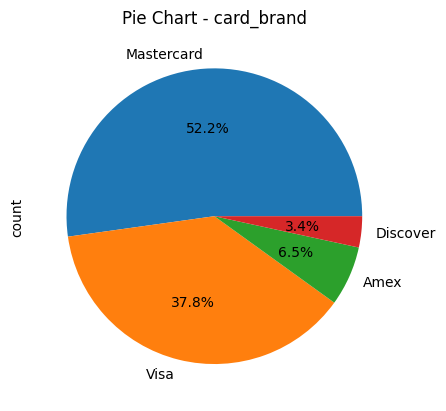

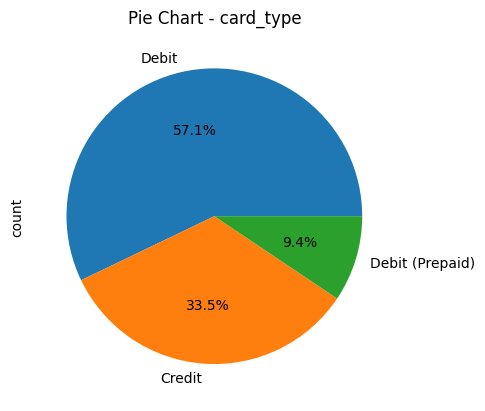

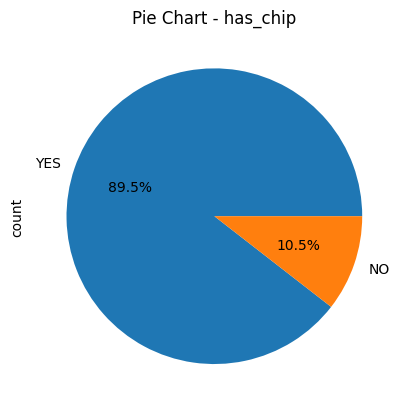

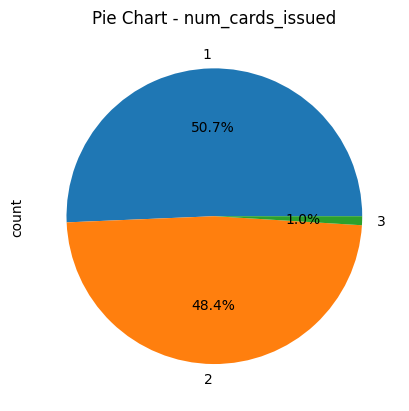

<Figure size 640x480 with 0 Axes>

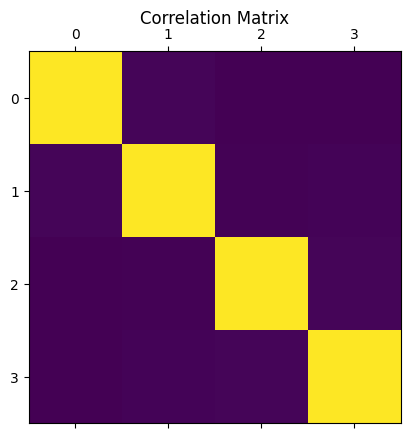

<Figure size 640x480 with 0 Axes>

In [13]:
# Графики
subset = pd.read_csv(output_file)

plt.figure(figsize=(10, 6))

numeric_cols = subset.select_dtypes(include=["number"])
if not numeric_cols.empty:
    col_name = numeric_cols.columns[0]
    numeric_cols.iloc[:, 0].plot(title=f"Line Plot - {col_name}")
    plt.show()
    plt.clf()

# Столбчатая диаграмма (категориальные или с небольшим числом уникальных значений)
for col in subset.columns:
    if subset[col].nunique() < 20:  # Подходит для категорий
        subset[col].value_counts().plot(kind="bar", title=f"Bar Plot - {col}")
        plt.show()
        plt.clf()

# Круговая диаграмма (категориальные данные)
for col in subset.columns:
    if subset[col].nunique() < 10:  # Подходит для небольшого числа категорий
        subset[col].value_counts().plot(kind="pie", title=f"Pie Chart - {col}", autopct="%1.1f%%")
        plt.show()
        plt.clf()

# Корреляция
if not numeric_cols.empty:
    correlation_matrix = numeric_cols.corr()
    plt.matshow(correlation_matrix)
    plt.title("Correlation Matrix", pad=20)
    plt.show()
    plt.clf()
